In [79]:
import pandas as pd
import numpy as np
import os
import time
import gc
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy import sparse

import seaborn as sns
from datetime import *
from functools import reduce
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
import datetime

import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from catboost import CatBoostClassifier as cb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score,f1_score
from lightgbm import *
plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_row', 300)
pd.set_option('display.float_format', lambda x: ' %.5f' % x)


In [80]:
import matplotlib
print("当前字体:", matplotlib.rcParams['font.family'])

当前字体: ['sans-serif']


In [81]:
#读取文件
def load_file(path,filename,data_source):
    df=pd.read_csv(path+filename+data_source+'.csv')
    return df
def count_notzero(series_x):
    mode = series_x[(series_x > 0)]
    return mode.count()

def count_zero(series_x):
    mode = series_x[(series_x == 0)]
    return mode.count()

def count_lesszero(series_x):
    mode = series_x[(series_x < 0)]
    return mode.count()

def sum_notzero(series_x):
    mode = series_x[(series_x > 0)]
    return mode.sum()

def sum_lesszero(series_x):
    mode = series_x[(series_x <0)]
    return mode.sum()
    
#计算CV的F2值
def compute_f2(label, predict):
    p = precision_score(label, predict) 
    r = recall_score(label, predict) 
    f2_score = 5*p*r / (4*p + r) 
    return f2_score
    
#计算CV的F2值
def compute_f1(label, predict):
    p = precision_score(label, predict) 
    r = recall_score(label, predict) 
    f2_score = 5*p*r / (4*p + r) 
    return f1_score


def corr_filter(train_data, corr_threshold):
    corr_data = train_data.corr()
    # 将 np.bool 改为 np.bool_
    corr_data = corr_data.where(
        np.triu(np.ones(corr_data.shape), k=1).astype(np.bool_)  # 修改这里
    )
    high_corr = [column for column in corr_data.columns 
                 if any(corr_data[column].abs() > corr_threshold)]
    result = [c for c in train_data.columns if c not in high_corr]
    print('筛选后的特征数量:', len(result))
    return result
    
#剔除极度缺失的特征（5%）
def null_filter(train_data,null_threshold):
    ratio_feature=train_data.isnull().sum()/train_data.shape[0]
    col=list(ratio_feature[ratio_feature<null_threshold].index)
    rm_col=[c for c in train_data.columns if c not in col]
    return col,rm_col
    
def 对抗验证(df_train,df_test,cats_list):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test],axis=0)
    cols_list=df_adv.columns.tolist()
    #cats_list=df_adv.select_dtypes(include='category').columns
    cats_list_idx=[i for i in range(len(cols_list)) if cols_list[i] in cats_list]

    for c in cats_list:
        le=LabelEncoder()
        df_adv[c]=df_adv[c].astype('str')
        df_adv[c].fillna('unknown')
        le.fit(df_adv[c])
        df_adv[c]=le.transform(df_adv[c])
        #df_adv[c]=df_adv[c].astype('float64')
        df_adv[c]=df_adv[c].astype('category')
    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':2**7-1,'max_depth':7,'n_estimators':10000,
                 'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.01}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])#,categorical_feature=cats_list_idx)
    preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})
    new_cat=im.loc[im.sort_values(by='importance',ascending=False)[round(len(im)*0.1):].index,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return im,new_cat

In [82]:
from sklearn.metrics import mean_squared_error  # 导入 RMSE 计算函数

def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 10
    seed = 2023
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])
    df_feature_importance = pd.DataFrame()
    cv_scores = []
    
    # 类别列处理
    cols_list = train_x.columns.tolist()
    cats_list = train_x.select_dtypes(include='category').columns
    cats_list_idx = [i for i in range(len(cols_list)) if cols_list[i] in cats_list]
    
    # XGBoost 和 CatBoost 的类别列预处理（保留原逻辑）
    if clf_name in ["xgb", "cat"]:
        for c in cats_list:
            le = LabelEncoder()
            train_x[c] = train_x[c].astype('str')
            test_x[c] = test_x[c].astype('str')
            lb_data = pd.concat([train_x[c], test_x[c]], axis=0)
            le.fit(lb_data)
            train_x[c] = le.transform(train_x[c])
            test_x[c] = le.transform(test_x[c])
        if clf_name == "xgb":
            train_x.replace(np.inf, 9999999, inplace=True)
            train_x.replace(-np.inf, -9999999, inplace=True)
            test_x.replace(np.inf, 9999999, inplace=True)
            test_x.replace(-np.inf, -9999999, inplace=True)
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ​************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            # LightGBM 参数（已适配回归）
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)
            callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=200)]
            params = {
                'device': 'gpu',          # 启用GPU
                'boost_from_average': 'false',
                'boost': 'gbdt',
                'metric': 'rmse',
                'max_depth': 7,
                'num_leaves': 2**7-1,
                'objective': 'regression',
                'min_child_weight': 16,
                'min_data_in_leaf': 6,
                'min_split_gain': 0.7,
                'bagging_fraction': 0.82,
                'feature_fraction': 0.74,
                'reg_lambda': 2.65,
                'reg_alpha': 3.85,
                'bagging_freq': 1,
                'seed': 2023,
                'nthread': 8,
                'n_jobs': 8,
                'verbose': -1
            }
            model = clf.train(params, train_matrix, num_boost_round=2000, valid_sets=[train_matrix, valid_matrix], callbacks=callbacks)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # 特征重要性
            df_fold_importance = pd.DataFrame()
            df_fold_importance['feature'] = train_x.columns
            df_fold_importance['importance'] = model.feature_importance()
            df_fold_importance['fold'] = i + 1
            df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

        elif clf_name == "xgb":
            # XGBoost 参数（适配回归）
            train_matrix = clf.DMatrix(trn_x, label=trn_y)
            valid_matrix = clf.DMatrix(val_x, label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {
                'booster': 'gbtree',
                'objective': 'reg:squarederror',  # 回归目标函数
                'eval_metric': 'rmse',            # 回归评估指标
                'gamma': 1,
                'min_child_weight': 1.5,
                'max_depth': 7,
                'lambda': 10,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'colsample_bylevel': 0.7,
                'eta': 0.05,
                'tree_method': 'exact',
                'seed': 2023,
                'nthread': 8
            }
            
            watchlist = [(train_matrix, 'train'), (valid_matrix, 'eval')]
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(valid_matrix)
            test_pred = model.predict(test_matrix)
            
            # 特征重要性
            df_fold_importance = pd.DataFrame()
            df_fold_importance['feature'] = model.get_score(importance_type='gain').keys()
            df_fold_importance['importance'] = model.get_score(importance_type='gain').values()
            df_fold_importance['fold'] = i + 1
            df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

        elif clf_name == "cat":
            # CatBoost 参数（适配回归）
            model = clf(
                iterations=10000,
                random_seed=2023,
                eval_metric='RMSE',          # 回归评估指标
                learning_rate=0.05,
                depth=5,
                early_stopping_rounds=200,
                metric_period=500,
                loss_function='RMSE',        # 回归损失函数
                verbose=1
            )
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y), cat_features=cats_list_idx)
            val_pred = model.predict(val_x)  # 回归直接使用 predict
            test_pred = model.predict(test_x)
            
            # 特征重要性
            df_fold_importance = pd.DataFrame()
            df_fold_importance['feature'] = train_x.columns
            df_fold_importance['importance'] = model.feature_importances_
            df_fold_importance['fold'] = i + 1
            df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

        # 保存预测结果
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        
        # 计算 RMSE
        rmse = mean_squared_error(val_y, val_pred, squared=False)
        cv_scores.append(rmse)
        print('CV RMSE: {:<8.5f}'.format(rmse))
    
    print("平均 RMSE:::", np.mean(cv_scores))
    return oof, predict, model, df_feature_importance

In [83]:
train_dir = "./data/1_预处理/train/"
test_dir = "./data/1_预处理/A/"

特征_train_dir = "./data/2_特征/train/"
特征_test_dir = "./data/2_特征/A/"

In [84]:
# 创建 df_train 和 df_test
date_range = pd.date_range(
    start='2014-01-01 00:00:00',
    end='2019-12-31 23:00:00',  # 包含最后一日的23:00
    freq='H'  # 每小时频率
)
df_train = pd.DataFrame(date_range, columns=['时间'])
date_range = pd.date_range(
    start='2020-01-01 00:00:00',
    end='2021-12-31 23:00:00',  # 包含最后一日的23:00
    freq='H'  # 每小时频率
)
df_test = pd.DataFrame(date_range, columns=['时间'])

In [85]:
for root, ds, fs in os.walk(特征_train_dir):
    for f in fs:
        print(f)
        with open(特征_train_dir + f , "rb" ) as file :
            df_train = df_train.merge(pickle.load(file) , on='时间' , how = 'left')
print("--------------------------------------------")
for root, ds, fs in os.walk(特征_test_dir):
    for f in fs:
        print(f)
        with open(特征_test_dir + f , "rb" ) as file :
            df_test = df_test.merge(pickle.load(file) , on='时间' , how = 'left')

1~36小时滑窗特征.pkl
基础特征.pkl
年月日季节.pkl
广东哥特征.pkl
--------------------------------------------
1~36小时滑窗特征.pkl
基础特征.pkl
年月日季节.pkl
广东哥特征.pkl


In [86]:
# 加上标签
with open(train_dir + '入库流量.pkl' , "rb" ) as file :
    df_train = df_train.merge(pickle.load(file) , on='时间' , how = 'left')

In [87]:
# 1、发现2014-06-30 01:00:00到2014-06-30 23:00:00这一天的FLAG是缺失的
df_train = df_train[~df_train['FLAG'].isna()].reset_index(drop=True).copy()

In [88]:
# feature_selected = [i for i in df_train.columns if i not in ['时间' , 'FLAG']]

In [89]:
feature_selected = ['下保村雨量_max_36h',
 '下保村雨量_max_48h',
 '下保村雨量_std_12h',
 '下保村雨量_std_36h',
 '下保村雨量_std_48h',
 '下墩村雨量_std_12h',
 '下洋坂雨量_std_3h',
 '下洋坂雨量_std_6h',
 '下路岭雨量_min_24h',
 '东上村雨量_sum_48h',
 '九丘雨量_max_24h',
 '厚德村雨量_min_48h',
 '双鲤村雨量_min_24h',
 '后村雨量_min_36h',
 '均中村雨量_max_12h',
 '均中村雨量_max_36h',
 '均中村雨量_max_48h',
 '均中村雨量_std_3h',
 '均中村雨量_std_36h',
 '均中村雨量_std_48h',
 '均中村雨量_sum_48h',
 '夏阳乡雨量_min_36h',
 '外洋村雨量_max_12h',
 '外洋村雨量_max_48h',
 '外洋村雨量_std_12h',
 '外洋村雨量_std_48h',
 '外洋村雨量_sum_48h',
 '大华镇雨量_max_48h',
 '大华镇雨量_min_24h',
 '大华镇雨量_sum_48h',
 '大口窑雨量_max_24h',
 '大口窑雨量_max_36h',
 '大口窑雨量_std_12h',
 '大口窑雨量_std_24h',
 '大口窑雨量_std_36h',
 '大口窑雨量_std_48h',
 '大横镇曲楼甲新农村雨量_max_36h',
 '大横镇曲楼甲新农村雨量_max_48h',
 '大横镇曲楼甲新农村雨量_std_3h',
 '大横镇曲楼甲新农村雨量_std_6h',
 '大横镇曲楼甲新农村雨量_std_24h',
 '大横镇曲楼甲新农村雨量_std_48h',
 '大横镇曲楼甲新农村雨量_sum_36h',
 '大横镇曲楼甲新农村雨量_sum_48h',
 '天心岛花园雨量_max_48h',
 '天心岛花园雨量_sum_36h',
 '安砂镇雨量_max_48h',
 '安砂镇雨量_std_24h',
 '富屯溪流域面雨量_max_6h',
 '富屯溪流域面雨量_max_36h',
 '富屯溪流域面雨量_max_48h',
 '富屯溪流域面雨量_min_6h',
 '富屯溪流域面雨量_min_12h',
 '富屯溪流域面雨量_sum_36h',
 '富屯溪流域面雨量_sum_48h',
 '小华村雨量_max_3h',
 '小华村雨量_min_24h',
 '小西门头社区雨量_max_48h',
 '山下乡雨量_max_12h',
 '山下乡雨量_max_48h',
 '山下乡雨量_std_36h',
 '山下乡雨量_sum_12h',
 '山下乡雨量_sum_48h',
 '山坊雨量_max_6h',
 '山坊雨量_max_48h',
 '山坊雨量_sum_36h',
 '山坊雨量_sum_48h',
 '岭坪雨量_max_48h',
 '岭坪雨量_min_6h',
 '岭坪雨量_std_3h',
 '岭坪雨量_std_6h',
 '岭坪雨量_std_36h',
 '岭坪雨量_std_48h',
 '岭坪雨量_sum_48h',
 '年坂山雨量_std_48h',
 '库区流域面雨量_max_48h',
 '建溪流域面雨量_max_48h',
 '建溪流域面雨量_min_36h',
 '建溪流域面雨量_min_48h',
 '建溪流域面雨量_sum_48h',
 '文峰村雨量_std_6h',
 '文峰村雨量_std_24h',
 '文峰村雨量_std_36h',
 '新桥头雨量_max_48h',
 '新桥头雨量_std_6h',
 '新桥头雨量_std_48h',
 '新桥头雨量_sum_24h',
 '新桥头雨量_sum_48h',
 '新源村雨量_max_36h',
 '新源村雨量_max_48h',
 '新源村雨量_std_6h',
 '新源村雨量_std_36h',
 '新源村雨量_std_48h',
 '新源村雨量_sum_36h',
 '新源村雨量_sum_48h',
 '景山新村雨量_min_48h',
 '杉坜雨量_std_3h',
 '杉坜雨量_std_6h',
 '杉坜雨量_std_36h',
 '杉坜雨量_std_48h',
 '杉坜雨量_sum_48h',
 '林后岗雨量_max_48h',
 '林后岗雨量_min_24h',
 '林后岗雨量_min_36h',
 '林后岗雨量_min_48h',
 '林后岗雨量_std_3h',
 '林后岗雨量_std_12h',
 '林后岗雨量_std_48h',
 '林后岗雨量_sum_24h',
 '林后岗雨量_sum_36h',
 '林后岗雨量_sum_48h',
 '柯坑村雨量_max_36h',
 '柯坑村雨量_max_48h',
 '桐木村雨量_max_12h',
 '桐木村雨量_max_24h',
 '桐木村雨量_max_36h',
 '桐木村雨量_std_36h',
 '桐木村雨量_std_48h',
 '桐木村雨量_sum_48h',
 '桥南村雨量_max_6h',
 '桥南村雨量_max_12h',
 '桥南村雨量_max_48h',
 '桥南村雨量_min_24h',
 '桥南村雨量_min_36h',
 '桥南村雨量_min_48h',
 '桥南村雨量_std_3h',
 '桥南村雨量_std_6h',
 '桥南村雨量_std_12h',
 '桥南村雨量_std_48h',
 '桥南村雨量_sum_36h',
 '桥南村雨量_sum_48h',
 '梅仙镇雨量_min_36h',
 '梅仙镇雨量_std_48h',
 '梅仙镇雨量_sum_48h',
 '梅园小区雨量_max_24h',
 '梅园小区雨量_min_24h',
 '梅园小区雨量_std_24h',
 '梅园小区雨量_sum_24h',
 '梅山镇雨量_min_48h',
 '梅树湾新村雨量_max_48h',
 '梅树湾新村雨量_sum_48h',
 '樟树村雨量_max_36h',
 '樟树村雨量_max_48h',
 '樟树村雨量_std_3h',
 '樟树村雨量_std_12h',
 '樟树村雨量_sum_36h',
 '樟树村雨量_sum_48h',
 '横洋雨量_std_12h',
 '民主村雨量_max_48h',
 '民主村雨量_min_24h',
 '民主村雨量_min_48h',
 '民主村雨量_sum_48h',
 '水东区间流域面雨量_max_24h',
 '水东区间流域面雨量_max_48h',
 '水东区间流域面雨量_std_12h',
 '水东区间流域面雨量_sum_3h',
 '水东区间流域面雨量_sum_6h',
 '水东区间流域面雨量_sum_36h',
 '水东区间流域面雨量_sum_48h',
 '水东坝上雨量_std_3h',
 '水东面雨量_max_36h',
 '水东面雨量_max_48h',
 '水东面雨量_std_48h',
 '水南村雨量_max_12h',
 '水南村雨量_max_48h',
 '水南村雨量_std_48h',
 '水南村雨量_sum_36h',
 '水南村雨量_sum_48h',
 '水口坝上(左岸)雨量_max_24h',
 '水口坝上(左岸)雨量_max_36h',
 '水口坝上(左岸)雨量_max_48h',
 '水口坝上(左岸)雨量_std_6h',
 '水口坝上(左岸)雨量_std_12h',
 '水口坝上(左岸)雨量_std_36h',
 '水口坝上(左岸)雨量_std_48h',
 '水口坝上雨量_max_36h',
 '水口坝上雨量_min_24h',
 '水口面雨量_max_24h',
 '水口面雨量_max_36h',
 '水口面雨量_max_48h',
 '水口面雨量_min_48h',
 '水口面雨量_sum_36h',
 '水口面雨量_sum_48h',
 '永坑村雨量_min_36h',
 '永坑村雨量_std_24h',
 '永坑村雨量_std_48h',
 '永坑村雨量_sum_48h',
 '沙坝下雨量_max_3h',
 '沙坝下雨量_max_48h',
 '沙坝下雨量_std_12h',
 '沙坝下雨量_std_48h',
 '沙溪流域面雨量_max_24h',
 '漈村雨量_sum_12h',
 '白叶山雨量_max_48h',
 '白叶山雨量_std_6h',
 '白叶山雨量_std_36h',
 '白叶山雨量_std_48h',
 '白叶山雨量_sum_48h',
 '白源雨量_max_36h',
 '白源雨量_max_48h',
 '白源雨量_std_3h',
 '白源雨量_std_6h',
 '白源雨量_std_48h',
 '石塔山雨量_max_24h',
 '石塔山雨量_max_48h',
 '石塔山雨量_std_48h',
 '石塔山雨量_sum_24h',
 '石塔山雨量_sum_48h',
 '福源小区雨量_std_3h',
 '福源小区雨量_sum_48h',
 '福记雨量_max_48h',
 '福记雨量_std_6h',
 '福记雨量_std_48h',
 '福记雨量_sum_48h',
 '端溪村雨量_max_36h',
 '端溪村雨量_max_48h',
 '端溪村雨量_std_6h',
 '端溪村雨量_sum_48h',
 '街面面雨量_max_48h',
 '街面面雨量_std_48h',
 '街面面雨量_sum_3h',
 '西城镇雨量_min_12h',
 '西城镇雨量_min_24h',
 '西城镇雨量_std_12h',
 '西津村雨量_max_48h',
 '西津村雨量_std_3h',
 '西津村雨量_std_6h',
 '西表村雨量_max_36h',
 '西表村雨量_max_48h',
 '西表村雨量_min_6h',
 '西表村雨量_std_3h',
 '西表村雨量_std_6h',
 '西表村雨量_std_12h',
 '西表村雨量_std_24h',
 '西表村雨量_std_36h',
 '西表村雨量_std_48h',
 '西表村雨量_sum_36h',
 '西表村雨量_sum_48h',
 '观华园雨量_sum_3h',
 '观华园雨量_sum_36h',
 '观华园雨量_sum_48h',
 '车洋坂雨量_std_12h',
 '车洋坂雨量_std_24h',
 '车洋坂雨量_std_48h',
 '车洋坂雨量_sum_36h',
 '车洋坂雨量_sum_48h',
 '里坪厂雨量_std_6h',
 '里洋村雨量_max_36h',
 '里洋村雨量_max_48h',
 '里洋村雨量_std_3h',
 '里洋村雨量_std_6h',
 '里洋村雨量_std_12h',
 '里洋村雨量_std_36h',
 '里洋村雨量_sum_12h',
 '里洋村雨量_sum_36h',
 '里洋村雨量_sum_48h',
 '金岭村雨量_max_36h',
 '金岭村雨量_max_48h',
 '金岭村雨量_std_3h',
 '金岭村雨量_std_6h',
 '金岭村雨量_std_48h',
 '金岭村雨量_sum_48h',
 '雍口实时面雨量_std_6h',
 '雍口实时面雨量_std_36h',
 '雍口面雨量_max_36h',
 '雍口面雨量_max_48h',
 '雍口面雨量_std_48h',
 '龙口村雨量_min_36h',
 '年份',
 '月份',
 '日',
 '小时',
 '季度',
 '水文时期编码'] + [
'v_sum' ,
'v_mean' ,
'v_std' ,
'v_max' ,
'v_min' ,
'v_skew' ,
'v_sum_diff' ,
'v_mean_diff' ,
'v_mean_roll_8' ,
'v_mean_roll_16' ,
'v_mean_roll_24' ,
'v_mean_roll_32' ,
'v_mean_roll_40' ,
'v_mean_roll_48' ,
'v_mean_roll_56' ,
'v_mean_roll_64' ,
'v_mean_roll_72' ,
'v_mean_roll_80' ,
'v_mean_roll_88' ,
'v_mean_roll_96' ,
'v_mean_roll_104' ,
'v_mean_roll_112' ,
'v_mean_roll_120' ,
'v_mean_roll_128' ,
'v_mean_roll_136' ,
'v_mean_roll_144' ,
'v_mean_roll_152' ,
'v_mean_roll_160' ,
'v_mean_roll_168' ,
'v_mean_roll_176' ,
'v_mean_roll_184' ,
'v_mean_roll_192' ,
'v_mean_roll_200' ,
'v_mean_roll_208' ,
'v_mean_roll_216' ,
'v_mean_roll_224' ,
'v_mean_roll_232' ,
'v_mean_roll_240' ,
'v_mean_roll_248' ,
'v_mean_roll_256' ,
'v_mean_roll_264' ,
'v_mean_roll_272' ,
'v_mean_roll_280' ,
'v_mean_roll_288' ,
'v_mean_roll_296' ,
'v_mean_roll_304' ,
'v_mean_roll_312' ,
'v_mean_roll_320' ,
'v_mean_roll_328' ,
'v_mean_roll_336' ,
'v_mean_roll_344' ,
'v_mean_roll_352' ,
'v_mean_roll_360' ,
'v_mean_roll_368' ,
'v_mean_roll_376' ,
'v_mean_roll_384' ,
'v_mean_roll_392' ,
'v_mean_roll_400' ,
'v_mean_roll_408' ,
'v_mean_roll_416' ,
'v_mean_roll_424' ,
'v_mean_roll_432' ,
'v_mean_roll_440' ,
'v_mean_roll_448' ,
'v_mean_roll_456' ,
'v_mean_roll_464' ,
'v_mean_roll_472' ,
'v_mean_roll_480' ,
'v_mean_roll_488' ,
'v_mean_roll_496' ,
'v_mean_roll_504' ,
'v_mean_roll_512' ,
'v_mean_roll_520' ,
'v_mean_roll_528' ,
'v_mean_roll_536' ,
'v_mean_roll_544' ,
'v_mean_roll_552' ,
'v_mean_roll_560' ,
'v_mean_roll_568' ,
'v_mean_roll_576' ,
'v_mean_roll_584' ,
'v_mean_roll_592' ,
'v_mean_roll_600' ,
'v_mean_roll_608' ,
'v_mean_roll_616' ,
'v_mean_roll_624' ,
'v_mean_roll_632' ,
'v_mean_roll_640' ,
'v_mean_roll_648' ,
'v_mean_roll_656' ,
'v_mean_roll_664' ,
'v_mean_roll_672' ,
'v_mean_roll_680' ,
'v_mean_roll_688' ,
'v_mean_roll_696' ,
'v_mean_roll_704' ,
'v_mean_roll_712' ,
'v_mean_roll_720'
]

In [90]:
feature_selected = ['下保村雨量_max_48h',
 '下保村雨量_std_12h',
 '下洋坂雨量_std_6h',
 '均中村雨量_max_36h',
 '均中村雨量_std_48h',
 '均中村雨量_sum_48h',
 '外洋村雨量_max_12h',
 '外洋村雨量_std_12h',
 '外洋村雨量_std_48h',
 '外洋村雨量_sum_48h',
 '大横镇曲楼甲新农村雨量_max_48h',
 '大横镇曲楼甲新农村雨量_std_48h',
 '大横镇曲楼甲新农村雨量_sum_48h',
 '富屯溪流域面雨量_min_12h',
 '富屯溪流域面雨量_sum_48h',
 '山下乡雨量_max_48h',
 '山下乡雨量_sum_48h',
 '岭坪雨量_max_48h',
 '岭坪雨量_std_36h',
 '建溪流域面雨量_max_48h',
 '建溪流域面雨量_sum_48h',
 '文峰村雨量_std_6h',
 '文峰村雨量_std_36h',
 '新源村雨量_max_48h',
 '杉坜雨量_std_6h',
 '杉坜雨量_std_48h',
 '杉坜雨量_sum_48h',
 '林后岗雨量_min_24h',
 '林后岗雨量_min_48h',
 '林后岗雨量_std_3h',
 '林后岗雨量_std_12h',
 '林后岗雨量_sum_48h',
 '柯坑村雨量_max_48h',
 '桥南村雨量_max_6h',
 '桥南村雨量_max_12h',
 '桥南村雨量_min_24h',
 '桥南村雨量_std_6h',
 '桥南村雨量_std_12h',
 '桥南村雨量_std_48h',
 '桥南村雨量_sum_48h',
 '梅园小区雨量_std_24h',
 '梅园小区雨量_sum_24h',
 '樟树村雨量_max_48h',
 '樟树村雨量_std_12h',
 '樟树村雨量_sum_36h',
 '樟树村雨量_sum_48h',
 '水东区间流域面雨量_max_48h',
 '水东区间流域面雨量_std_12h',
 '水南村雨量_sum_36h',
 '水南村雨量_sum_48h',
 '水口坝上(左岸)雨量_max_36h',
 '水口坝上(左岸)雨量_max_48h',
 '水口坝上(左岸)雨量_std_6h',
 '水口坝上(左岸)雨量_std_12h',
 '水口坝上(左岸)雨量_std_36h',
 '水口坝上(左岸)雨量_std_48h',
 '水口面雨量_max_36h',
 '水口面雨量_max_48h',
 '水口面雨量_min_48h',
 '水口面雨量_sum_48h',
 '永坑村雨量_std_48h',
 '沙坝下雨量_max_48h',
 '白叶山雨量_max_48h',
 '白叶山雨量_std_36h',
 '白源雨量_std_6h',
 '白源雨量_std_48h',
 '石塔山雨量_max_24h',
 '石塔山雨量_max_48h',
 '石塔山雨量_std_48h',
 '福源小区雨量_std_3h',
 '端溪村雨量_std_6h',
 '西津村雨量_std_3h',
 '西津村雨量_std_6h',
 '西表村雨量_max_36h',
 '西表村雨量_max_48h',
 '西表村雨量_std_36h',
 '西表村雨量_std_48h',
 '西表村雨量_sum_48h',
 '车洋坂雨量_std_12h',
 '里洋村雨量_max_48h',
 '里洋村雨量_std_3h',
 '金岭村雨量_std_3h',
 '金岭村雨量_sum_48h',
 '雍口实时面雨量_std_6h',
 '雍口实时面雨量_std_36h',
 '雍口面雨量_max_48h',
 '雍口面雨量_std_48h',
 '年份',
 '月份',
 '小时',
 '季度',
 '水文时期编码',
 'v_mean_roll_72',
 'v_mean_roll_176',
 'v_mean_roll_184',
 'v_mean_roll_192',
 'v_mean_roll_232',
 'v_mean_roll_368',
 'v_mean_roll_384',
 'v_mean_roll_392',
 'v_mean_roll_408',
 'v_mean_roll_464',
 'v_mean_roll_552',
 'v_mean_roll_560',
 'v_mean_roll_656',
 'v_mean_roll_696',
 'v_mean_roll_704',
 'v_mean_roll_712',
 'v_mean_roll_720']

In [91]:
len(feature_selected)

109

In [92]:
# df_剔除共线性特征 = corr_filter(df_train.drop(['时间' , 'FLAG'] , axis=1) , 0.95)
# feature_selected = df_剔除共线性特征

In [93]:
feature_selected

['下保村雨量_max_48h',
 '下保村雨量_std_12h',
 '下洋坂雨量_std_6h',
 '均中村雨量_max_36h',
 '均中村雨量_std_48h',
 '均中村雨量_sum_48h',
 '外洋村雨量_max_12h',
 '外洋村雨量_std_12h',
 '外洋村雨量_std_48h',
 '外洋村雨量_sum_48h',
 '大横镇曲楼甲新农村雨量_max_48h',
 '大横镇曲楼甲新农村雨量_std_48h',
 '大横镇曲楼甲新农村雨量_sum_48h',
 '富屯溪流域面雨量_min_12h',
 '富屯溪流域面雨量_sum_48h',
 '山下乡雨量_max_48h',
 '山下乡雨量_sum_48h',
 '岭坪雨量_max_48h',
 '岭坪雨量_std_36h',
 '建溪流域面雨量_max_48h',
 '建溪流域面雨量_sum_48h',
 '文峰村雨量_std_6h',
 '文峰村雨量_std_36h',
 '新源村雨量_max_48h',
 '杉坜雨量_std_6h',
 '杉坜雨量_std_48h',
 '杉坜雨量_sum_48h',
 '林后岗雨量_min_24h',
 '林后岗雨量_min_48h',
 '林后岗雨量_std_3h',
 '林后岗雨量_std_12h',
 '林后岗雨量_sum_48h',
 '柯坑村雨量_max_48h',
 '桥南村雨量_max_6h',
 '桥南村雨量_max_12h',
 '桥南村雨量_min_24h',
 '桥南村雨量_std_6h',
 '桥南村雨量_std_12h',
 '桥南村雨量_std_48h',
 '桥南村雨量_sum_48h',
 '梅园小区雨量_std_24h',
 '梅园小区雨量_sum_24h',
 '樟树村雨量_max_48h',
 '樟树村雨量_std_12h',
 '樟树村雨量_sum_36h',
 '樟树村雨量_sum_48h',
 '水东区间流域面雨量_max_48h',
 '水东区间流域面雨量_std_12h',
 '水南村雨量_sum_36h',
 '水南村雨量_sum_48h',
 '水口坝上(左岸)雨量_max_36h',
 '水口坝上(左岸)雨量_max_48h',
 '水口坝上(左岸)雨量_std_6h',
 '水口坝

In [94]:
X = df_train[feature_selected]
y = df_train['FLAG']
X_test = df_test[feature_selected]

In [95]:
lgb_oof, lgb_pred,clf,df_importance = cv_model(lgb, df_train[feature_selected], df_train['FLAG'], df_test[feature_selected], 'lgb')

************************************ 1 ​************************************
[LightGBM] [Warning] num_threads is set with nthread=8, will be overridden by n_jobs=8. Current value: num_threads=8
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 530.389	valid_1's rmse: 580.27
[200]	training's rmse: 481.638	valid_1's rmse: 562.017
[300]	training's rmse: 453.956	valid_1's rmse: 556.035
[400]	training's rmse: 430.697	valid_1's rmse: 554.859
[500]	training's rmse: 412.121	valid_1's rmse: 554.367
[600]	training's rmse: 395.104	valid_1's rmse: 554.179
[700]	training's rmse: 381.519	valid_1's rmse: 554.619
[800]	training's rmse: 369.528	valid_1's rmse: 555.569
Early stopping, best iteration is:
[615]	training's rmse: 393.108	valid_1's rmse: 553.946
CV RMSE: 553.94582
************************************ 2 ​************************************
[LightGBM] [Warning] num_threads is set with nthread=8, will be overridden by n_jobs=8. Current value: num_threads=8
Tr

In [ ]:
# 平均 RMSE::: 871.3494824440086
# 平均 RMSE::: 657.7929322746893
# 平均 RMSE::: 659.2026277804612
# 平均 RMSE::: 619.31288438066
# 平均 RMSE::: 571.0071618622376
# 平均 RMSE::: 567.2978923534296
# 平均 RMSE::: 564.3000168197361
# 平均 RMSE::: 562.8173117029409

In [100]:
lgb_pred

array([ 910.00055839,  728.43569331,  746.79573621, ..., 1721.39444051,
       1829.96416232, 1966.75334626])

In [101]:
结果 = df_test[['时间']].copy()
结果['V'] = lgb_pred
结果.columns = ['TIME' , 'V']

In [99]:
0/0

ZeroDivisionError: division by zero

In [102]:
结果.to_csv('./2025032805.csv' , index=None)

In [103]:
结果['V'].describe()

count    17544.00000
mean      1966.71107
std       1466.04165
min         61.66106
25%       1212.59181
50%       1652.23485
75%       2178.13651
max      14951.51928
Name: V, dtype: float64

In [104]:
df_train['FLAG'].describe()

count    52561.00000
mean      1888.35014
std       2065.15729
min      -2318.19500
25%        605.17500
50%       1326.65200
75%       2490.61200
max      22461.40700
Name: FLAG, dtype: float64

### 画图

In [105]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
from datetime import datetime
import os

# ------------------------- 设置中文字体（全局配置）-------------------------
# 注意：这里需要使用绝对路径！
font_path = os.path.abspath('FZBIAOYSJW.ttf')  # 转换为绝对路径
assert os.path.exists(font_path), f"字体文件不存在：{font_path}"  # 验证路径

# 加载字体并全局配置
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()  # 设置全局字体族
plt.rcParams['axes.unicode_minus'] = False          # 解决负号显示问题

# ------------------------- 特征重要性绘图函数 -------------------------
def plot_feature_importance(df_feature_importance, top_n=20, save_image=True):
    # 聚合特征重要性
    feature_importance = (
        df_feature_importance.groupby('feature')['importance']
        .mean()
        .reset_index()
        .sort_values(by='importance', ascending=False)
        .head(top_n)
    )
    
    # 动态调整图表高度
    fig_height = max(6, top_n * 0.5)
    plt.figure(figsize=(12, fig_height))
    sns.set_style("whitegrid")
    
    # 处理长特征名（自动换行）
    feature_importance['wrapped_feature'] = feature_importance['feature'].apply(
        lambda x: '\n'.join([x[i:i+30] for i in range(0, len(x), 30)])
    )
    
    # 绘制图表
    ax = sns.barplot(
        x="importance", 
        y="wrapped_feature", 
        data=feature_importance,
        palette="viridis"
    )
    
    # 装饰图表（显式指定字体属性）
    ax.set_title(
        f"特征重要性 Top {top_n} (LightGBM)",
        fontproperties=font_prop,  # 关键：强制使用自定义字体
        fontsize=14,
        pad=20
    )
    ax.set_xlabel(
        "重要性得分（跨折平均）", 
        fontproperties=font_prop,  # 关键
        fontsize=12, 
        labelpad=10
    )
    
    # 设置坐标轴标签字体
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)
        label.set_fontsize(10)
        
    plt.subplots_adjust(left=0.3)
    if save_image:
        # 自动生成带时间戳的文件名
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"feature_importance_{timestamp}.png"
        
        # 高级保存参数
        save_args = {
            'dpi': 300,               # 印刷级分辨率
            'bbox_inches': 'tight',   # 自动裁剪白边
            'pad_inches': 0.1,        # 内边距
            'transparent': False,     # 透明背景
            'facecolor': 'white',     # 背景色
            'metadata': {
                'Title': "特征重要性分析",
                'Author': "Your Name",
                'Copyright': "Company Name"
            }
        }
        plt.savefig(filename, **save_args)
        print(f"图片已保存为: {os.path.abspath(filename)}")  # 打印完整保存路径
    
    plt.show()

图片已保存为: e:\桌面\个人\1_数据挖掘\MinJiang\feature_importance_20250328_015554.png


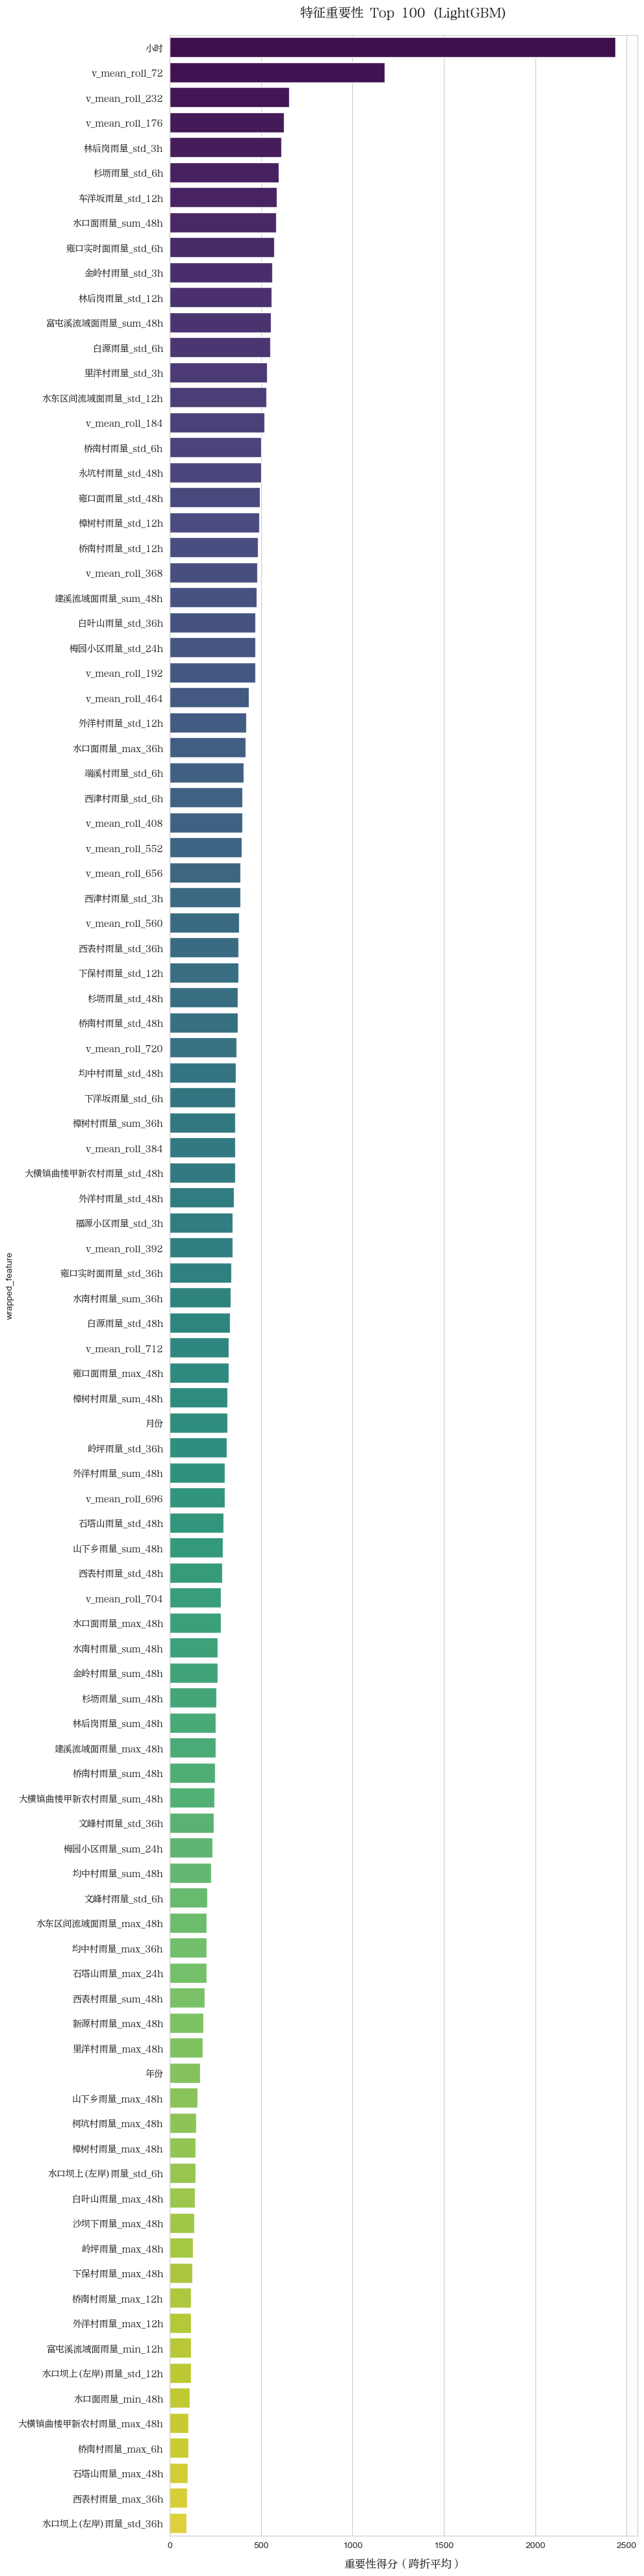

In [106]:
plot_feature_importance(df_importance , 100)

In [ ]:
import matplotlib
print("Matplotlib 字体目录:", matplotlib.get_cachedir() + "/fonts/")

Matplotlib 字体目录: C:\Users\14714\.matplotlib/fonts/


In [ ]:
import matplotlib.font_manager as fm

# 获取系统所有字体
font_list = [font.name for font in fm.fontManager.ttflist if any('CJK' in font.name or '宋体' in font.name or '微软雅黑' in font.name for font in fm.fontManager.ttflist)]
print("可用中文字体:", sorted(set(font_list)))

可用中文字体: []
